In [15]:
%pylab inline
#Import code from previous videos:
# from part5 import *

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [16]:
# X = (hours sleeping, hours studying), y = Score on test
X = np.array(([3,5], [5,1], [10,2]), dtype=float)
y = np.array(([75], [82], [93]), dtype=float)

In [17]:
from scipy import optimize

In [18]:
class NeuralNetwork(object):
    def __init__(self):        
        #Define Hyperparameters
        self.inputLayerSize = 2
        self.outputLayerSize = 1
        self.hiddenLayerSize = 3
        
        #Weights (parameters)
        self.W1 = np.random.randn(self.inputLayerSize,self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize,self.outputLayerSize)
        
    def forwardPropagation(self, X):
        #Propogate inputs though network
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        yHat = self.sigmoid(self.z3) 
        return yHat
        
    def sigmoid(self, z):
        #Apply sigmoid activation function to scalar, vector, or matrix
        return 1/(1+np.exp(-z))
    
    def sigmoidPrime(self,z):
        #Gradient of sigmoid
        return np.exp(-z)/((1+np.exp(-z))**2)
    
    def costFunction(self, X, y):
        #Compute cost for given X,y, use weights already stored in class.
        self.yHat = self.forwardPropagation(X)
        J = 0.5*sum((y-self.yHat)**2)
        return J
        
    def costFunctionPrime(self, X, y):
        #Compute derivative with respect to W1 and W2 for a given X and y:
        self.yHat = self.forwardPropagation(X)
        
        delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
        dJdW2 = np.dot(self.a2.T, delta3)
        
        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        dJdW1 = np.dot(X.T, delta2)  
        
        return dJdW1, dJdW2
    
    #Helper Functions for interacting with other classes:
    def getParams(self):
        #Get W1 and W2 unrolled into vector:
        params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
        return params
    
    def setParams(self, params):
        #Set W1 and W2 using single paramater vector.
        W1_start = 0
        W1_end = self.hiddenLayerSize * self.inputLayerSize
        self.W1 = np.reshape(params[W1_start:W1_end], (self.inputLayerSize , self.hiddenLayerSize))
        W2_end = W1_end + self.hiddenLayerSize*self.outputLayerSize
        self.W2 = np.reshape(params[W1_end:W2_end], (self.hiddenLayerSize, self.outputLayerSize))
        
    def computeGradients(self, X, y):
        dJdW1, dJdW2 = self.costFunctionPrime(X, y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))

In [19]:
class Trainer(object):
    def __init__(self, N):
        #Make Local reference to network:
        self.N = N
        
    def callbackF(self, params):
        self.N.setParams(params)
        self.J.append(self.N.costFunction(self.X, self.y))   
        
    def costFunctionWrapper(self, params, X, y):
        self.N.setParams(params)
        cost = self.N.costFunction(X, y)
        grad = self.N.computeGradients(X,y)
        
        return cost, grad
        
    def train(self, X, y):
        #Make an internal variable for the callback function:
        self.X = X
        self.y = y

        #Make empty list to store costs:
        self.J = []
        
        params0 = self.N.getParams()

        options = {'maxiter': 200, 'disp' : True}
        _res = optimize.minimize(self.costFunctionWrapper, params0, \
                                 jac=True, method='BFGS', \
                                 args=(X, y), options=options, \
                                 callback=self.callbackF)

        self.N.setParams(_res.x)
        self.optimizationResults = _res

In [20]:
NN = NeuralNetwork()

In [21]:
X

array([[ 3.,  5.],
       [ 5.,  1.],
       [10.,  2.]])

In [22]:
y

array([[75.],
       [82.],
       [93.]])

In [23]:
T = Trainer(NN)

In [24]:
T.train(X,y)

Optimization terminated successfully.
         Current function value: 10250.500004
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22


Text(0, 0.5, 'Cost (J)')

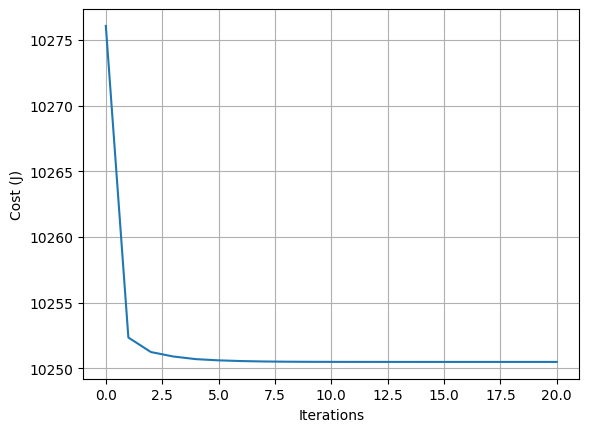

In [25]:
plot(T.J)
grid(1)
xlabel('Iterations')
ylabel('Cost (J)')

In [26]:
NN.costFunctionPrime(X,y)

(array([[-1.22946296e-09, -9.84436959e-06,  6.08104615e-10],
        [-1.52993467e-09, -7.19757487e-06,  1.70548146e-10]]),
 array([[-4.43905359e-06],
        [-3.23751304e-06],
        [-4.43904092e-06]]))

In [27]:
NN.forwardPropagation(X)

array([[0.99999997],
       [0.99999998],
       [0.99999999]])

In [28]:
y

array([[75.],
       [82.],
       [93.]])

In [29]:
#Test network for various combinations of sleep/study:
hoursSleep = linspace(0, 10, 100)
hoursStudy = linspace(0, 5, 100)

#Normalize data (same way training data way normalized)
hoursSleepNorm = hoursSleep/10.
hoursStudyNorm = hoursStudy/5.

#Create 2-d versions of input for plotting
a, b  = meshgrid(hoursSleepNorm, hoursStudyNorm)

#Join into a single input matrix:
allInputs = np.zeros((a.size, 2))
allInputs[:, 0] = a.ravel()
allInputs[:, 1] = b.ravel()

In [30]:
allOutputs = NN.forwardPropagation(allInputs)

Text(0, 0.5, 'Hours Study')

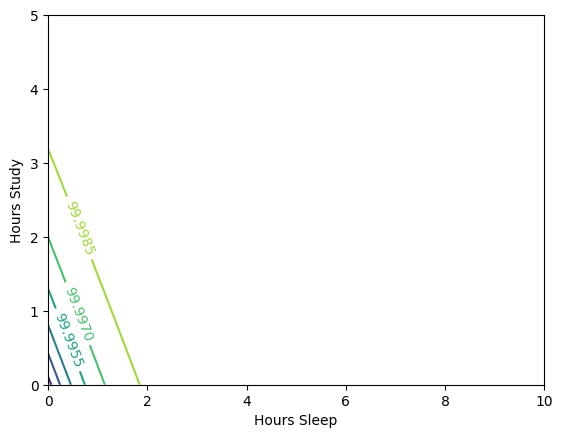

In [31]:
#Contour Plot:
yy = np.dot(hoursStudy.reshape(100,1), np.ones((1,100)))
xx = np.dot(hoursSleep.reshape(100,1), np.ones((1,100))).T

CS = contour(xx,yy,100*allOutputs.reshape(100, 100))
clabel(CS, inline=1, fontsize=10)
xlabel('Hours Sleep')
ylabel('Hours Study')

In [32]:
X

array([[ 3.,  5.],
       [ 5.,  1.],
       [10.,  2.]])